In [1]:
# import packages
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl

# Predicting 12-Month Rates, using 30 day windows of 3-Month, 6-Month, and Fed Funds Rate

## Data Wrangling

In [2]:
start_date = "1982-01-04"
end_date = "2016-03-11"

In [3]:
# read in Fed Funds Rate, 3-Month, 6-Month, 12-Month Treasury Bill data from Quandl
three_month = Quandl.get("FRED/DGS3MO", trim_start=start_date, trim_end=end_date)
six_month = Quandl.get("FRED/DGS6MO", trim_start=start_date, trim_end=end_date)
twelve_month = Quandl.get("FRED/DGS1", trim_start=start_date, trim_end=end_date)
fed_rate = Quandl.get("FRED/DFF", trim_start=start_date, trim_end=end_date)

In [4]:
# reset indices 
three_month.reset_index(level=0, inplace=True)
six_month.reset_index(level=0, inplace=True)
twelve_month.reset_index(level=0, inplace=True)
fed_rate.reset_index(level=0, inplace=True)

In [5]:
# normalize data to heave mean = 0, std = 1
three_month['normal'] = (three_month['VALUE'] - three_month['VALUE'].mean(axis=0)) / three_month['VALUE'].std(axis=0, ddof=1)
six_month['normal'] = (six_month['VALUE'] - six_month['VALUE'].mean(axis=0)) / six_month['VALUE'].std(axis=0, ddof=1)
twelve_month['normal'] = (twelve_month['VALUE'] - twelve_month['VALUE'].mean(axis=0)) / twelve_month['VALUE'].std(axis=0, ddof=1)
fed_rate['normal'] = (fed_rate['VALUE'] - fed_rate['VALUE'].mean(axis=0)) / fed_rate['VALUE'].std(axis=0, ddof=1)

In [6]:
# merge into single DataFrame
data = three_month.merge(six_month, on = 'DATE')
data = data.merge(twelve_month, on = 'DATE')
data = data.merge(fed_rate, on = 'DATE')

In [7]:
# rename columns
data.columns = ['date', '3_rate', '3_norm', '6_rate', '6_norm', '12_rate', '12_norm', 'fed_rate', 'fed_norm']

In [8]:
data.head(10)

,date,3_rate,3_norm,6_rate,6_norm,12_rate,12_norm,fed_rate,fed_norm
0,1982-01-04,11.87,2.437347,13.16,2.697099,13.56,2.716456,13.31,2.650399
1,1982-01-05,12.20,2.541979,13.41,2.773836,13.83,2.797861,12.90,2.527964
2,1982-01-06,12.16,2.529296,13.46,2.789183,13.91,2.821981,12.12,2.295037
3,1982-01-07,12.17,2.532467,13.43,2.779975,13.93,2.828011,12.37,2.369693
4,1982-01-08,11.98,2.472224,13.35,2.755419,13.75,2.773741,12.12,2.295037
5,1982-01-11,12.49,2.633928,13.84,2.905824,14.31,2.942580,12.64,2.450322
6,1982-01-12,12.52,2.643440,13.74,2.875129,14.18,2.903385,12.88,2.521991
7,1982-01-13,12.70,2.700512,13.97,2.945727,14.51,3.002880,12.66,2.456294
8,1982-01-14,13.17,2.849533,13.91,2.927310,14.41,2.972730,12.75,2.483170
9,1982-01-15,12.74,2.713194,14.01,2.958005,14.53,3.008910,12.47,2.399556


## Window 

In [9]:
index_count = 0

# create first entries of the sampling window
window_x = (data[['3_norm', '6_norm', 'fed_norm']].values[0:30]).reshape((1,90))
window_y = (data[['12_norm']].values[0:30]).reshape((1,30))

# iterate through the dataframe and append each successive sampling window
for i in xrange(30,8550,30):
    temp_x = (data[['3_norm', '6_norm', 'fed_norm']].values[i:i+30]).reshape((1,90))
    window_x = np.concatenate((window_x, temp_x))
    
    temp_y = (data[['12_norm']].values[i:i+30]).reshape((1,30))
    window_y = np.concatenate((window_y, temp_y)) 

    index_count += 1

In [10]:
# print shape of x window
window_x.shape

(285, 90)

In [11]:
# print shape of y window
window_y.shape

(285, 30)

## Train/Test Split

In [12]:
# concatenate x's and y's
window_x_y = np.concatenate((window_x, window_y), axis=1)

In [13]:
# print final window shape
window_x_y.shape

(285, 120)

In [14]:
# set random seed
np.random.seed(3232016)

# randomize the order of the window
np.random.shuffle(window_x_y)
window_x_y

array([[-1.30720101, -1.29015773, -1.2884454 , ..., -1.26030584,
        -1.2482459 , -1.25729085],
       [ 0.54763431,  0.54539233,  0.45850245, ...,  0.53360894,
         0.51551904,  0.48536921],
       [ 1.19444868,  1.04878733,  1.2080476 , ...,  1.05520096,
         1.04012605,  1.03409608],
       ..., 
       [ 0.53812233,  0.54232285,  0.50030975, ...,  0.54868385,
         0.54566887,  0.54868385],
       [ 0.31300557,  0.27220846,  0.32710808, ...,  0.28939533,
         0.32557512,  0.31653017],
       [ 0.22105647,  0.16784608,  0.3032182 , ..., -0.18998694,
        -0.17189704, -0.15983711]])

In [15]:
# determine length for training set
train_length = (len(window_x_y)/3)*2
train_length

190

In [16]:
# allocate train data
train_data = window_x_y[:train_length,:]

# allocate test data
test_data = window_x_y[train_length:,:]

In [17]:
# print train data shape
train_data.shape

(190, 120)

In [18]:
# print test data shape
test_data.shape

(95, 120)

In [19]:
# allocate x and y of train data
x_train = train_data[:,:90]
y_train = train_data[:,90:]

# allocate x and y of test data
x_test = test_data[:,:90]
y_test = test_data[:,90:]

## Neural Network

In [20]:
from function_approximator import FunctionApproximator

# set random seed
np.random.seed(3232016)

# define the function approximator
fa = FunctionApproximator(n_in=90, n_out=30, n_hidden=5)

# train the model
fa.train(x_train, y_train, learning_rate=0.05, n_epochs=200000, report_frequency=20000)

epoch: 20000  cost: 0.003784
epoch: 40000  cost: 0.002340
epoch: 60000  cost: 0.001825
epoch: 80000  cost: 0.001640
epoch: 100000  cost: 0.001536
epoch: 120000  cost: 0.001456
epoch: 140000  cost: 0.001391
epoch: 160000  cost: 0.001336
epoch: 180000  cost: 0.001290
epoch: 200000  cost: 0.001251


In [21]:
# print mean squared error of test set
y_bar = fa.get_y_pred(x_test)
print (((y_test - y_bar) ** 2).mean(axis=0))

[ 0.00740019  0.00661333  0.00576211  0.00568934  0.00551399  0.00568799
  0.00722347  0.0072308   0.00809735  0.01004717  0.00845746  0.00891079
  0.01004649  0.01042547  0.00831443  0.00737781  0.00643864  0.00595698
  0.00644466  0.00650928  0.00702151  0.00655789  0.00725199  0.00629665
  0.00698591  0.00727624  0.00663656  0.00722564  0.00784526  0.00867688]


In [22]:
# reshape for plotting purposes
y_test_plot = y_test.reshape(2850,1)
y_bar_plot = y_bar.reshape(2850,1)

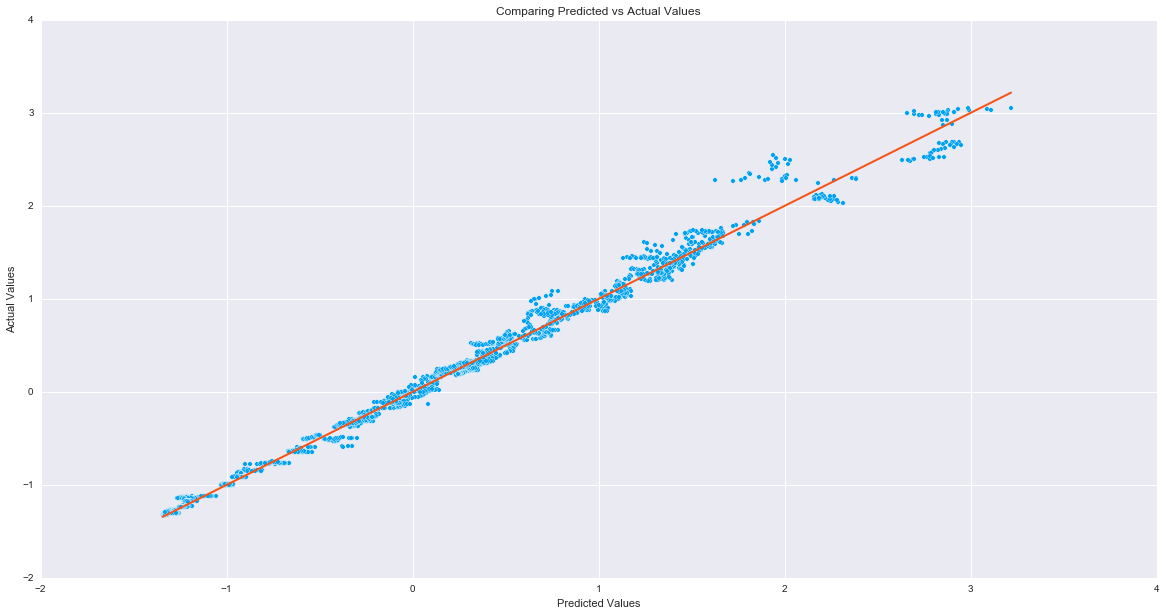

In [23]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.scatter(y_test_plot , y_bar_plot, color='#00A1F1', edgecolors='white')
plt.plot( [np.min(y_test_plot), np.max(y_test_plot)], [np.min(y_test_plot),np.max(y_test_plot)], linewidth=2, color='#F65314')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Comparing Predicted vs Actual Values')